# INF8111 - Fouille de données


## TP2 Automne 2019 - Extraction et analyse d'une base de données de tweets

##### Membres de l'équipe:

    - Yacine Benouniche (1733049) 1
    - Ghassen Cherni (1732397) 2


## Présentation du problème

En 2017, Twitter compte 313 millions d’utilisateurs actifs par mois avec 500 millions de tweets envoyés par jour. Cette information est rendue disponible à destination de la recherche et du développement web grâce à une API publique qui permet de collecter les informations que l'on souhaite.

Néanmoins, la politique de développement de Twitter limite le partage de ces données. En effet, le partage du contenu des tweets dans une base de données n'est pas autorisé, seuls les identifiants des tweets le sont. 
Pour partager publiquement une base de données de tweets que l'on a créée, il faut que cette base de données ne soit consituée que des identifiants de tweets, et c'est ce que l'on retrouve dans la plupart des jeux de données publiques.

Il est donc nécessaire pour exploiter ces données "d'hydrater" les tweets en question, c'est-à-dire extraire l'ensemble des informations à partir de l'ID, ce qui demande d'utiliser l'API de Twitter.

Nous allons ici utiliser des bases de données publiques créées par GWU (George Washington University), qui ont l'avantage d'être très récentes : 
https://dataverse.harvard.edu/dataverse/gwu-libraries

Chaque base de données de GWU couvre un sujet précis (élection américaine de 2016, jeux olympiques, etc.), et les données ont été recueillis en appliquant des requêtes qui filtraient les résultats pour n'avoir que des tweets pertinents. Un fichier README est fourni avec chaque base de données pour donner les détails de création du *dataset*. 


**Les objectifs de ce TP sont donc les suivants :**

 1. Construire un *crawler* qui collecte les informations d'un tweet à partir de son ID, avec le jeu de données de son choix et les informations pertinentes pour le sujet choisi
 2. A partir de ces données de Twitter collectés, application de méthodes en Machine Learning (ML)/Natural Language Processing (NLP) pour fournir une analyse pertinente. 


Twitter autorisant le partage **local** des données (par exemple au sein d'un groupe de recherche), une base de données sera fournie si vous ne parvenez pas à créer la vôtre.

# I/ Hydratation de tweets à l'aide de l'API Twitter (4 Pts)

### 1. Obtenir l'authorisation de Twitter pour l'utilisation de l'API

Pour l'authentification, Twitter utilise OAuth : https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
Vous aurez ici besoin en particulier de OAuth2, car vous n'allez pas interagir avec des utilisateurs sur Twitter (simplement collectés des données).

##### 1.1. Obtention d'un compte Twitter développeur

 La première étape nécessaire pour enregistrer votre application et de créer un compte Twitter développeur. Pour ce faire :

 - Créez un compte Twitter classique si vous n'en avez pas déjà un.
 
 - Sur le site, https://developer.twitter.com, cliquez sur *apply* pour obtenir un compte développeur. 
 
 - Remplissez tous les champs nécessaires. Twitter demande beaucoup de détails sur l'utilisation que vous allez faire de ce compte, il est donc important d'expliquer la démarche en détail : il faut souligner le fait que le projet est **académique** (aucune intention commerciale, aucune publication des données collectés, etc.), expliquer les objectifs et l'apprentissage de ce TP (prise en main de l'API Twitter, l'application concrète de méthodes de Data Mining, etc.), mais aussi expliquer en détail ce que vous allez faire des données (en reprenant des consignes du sujet), les méthodes que vous allez appliquer (citez des méthodes vues en cours ou au précédent TP), le rendu fourni (insistez sur le fait que rien ne sera publique), etc. Pensez notamment à indiquer le nom du cours et le sigle du cours, le nom de l'établissement, mon nom (Théo Moins), etc. Cochez que vous n'utiliserez pas la fonctionnalité de Retweet, et que l'aggregation et l'affichage de tweets ne sera fait que dans un cadre pédagogique (non publique, et sous la forme d'un projet de recherche). Si jamais vous n'êtes pas assez précis, Twitter peut vous renvoyer un courriel pour vous demander des précisions. 

##### 1.2. Obtention d'un jeton d'accès

 - Lorsque Twitter aura validé votre demande de compte développeur, allez sur https://developer.twitter.com/en/apps pour créer une application (cliquer sur *create an app*)

- Ici encore, des informations sont à fournir ici. Certaines, comme le nom ou le site internet, ne sont pas très importante, vous pouvez mettre un site internet factice si vous le souhaitez.

- A la fin de ce processus, vous pouvez enfin obtenir les clés et les jetons pour utiliser l'API: allez sur la page de l'application pour créer les jetons. Vous devez récupérer une paire de clés et une paire de jetons pour passer à la suite.



In [2]:
CONSUMER_KEY = "RDM5DRqyDGbgEL6KkhMPQgsg5"
CONSUMER_SECRET = "EMzeitzvJlf4EtLt7nyca0j5WwIIZnECtAZTk8Mpf8U4jGL1J7"

oauth_token = "829472346-p0Tn4AJ6m91pE0Xyedihl9uB89U9CVUSXwTZTTHl"
oauth_secret = "ynscO3or3Vjs1Ez7WedDqyztuWFpfZZYzXY1W52azAUX3"

###  2. Premiers pas avec Twython

##### 2.1 Installation et import de la librairie


Plusieurs librairies Python existent pour manipuler l'API Twitter. Aussi appelé *wrappers*, ce sont un ensemble de fonctions python qui appelle des fonctions de l'API. Parmi elles, nous utiliserons Twython, librairie répendue et activement maintenue.

Documentation de Twython : https://twython.readthedocs.io/en/latest/api.html 

In [4]:
import csv
import os
import time
import sys
import pandas as pd
import math
import numpy as np
import json
import re
import string
from bs4 import BeautifulSoup
from html import unescape
import matplotlib.pyplot as plt
import requests
from googletrans import Translator
try:
    from twython import Twython, TwythonError, TwythonRateLimitError
except ImportError:
    !pip3 install --user twython

    
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
#import Levenshtein
    

    
import gensim
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
from gensim.models import CoherenceModel
    
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

C:\Users\Ghassen Cherni\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
[nltk_data] Downloading package punkt to C:\Users\Ghassen
[nltk_data]     Cherni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ghassen
[nltk_data]     Cherni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ghassen Cherni\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to C:\Users\Ghassen
[nltk_data]     Cherni\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


##### 2.2 Création d'une application et premiers tests:

In [5]:
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, oauth_token, oauth_secret)

Voici un test avec une recherche très simple pour vous assurer que la requête fonctionne.

La fonction search renvoie une recherche (non exhaustive) de tweets, et l'option "*popular*" permet de retourner les résultats les plus populaires de la réponse. (documentation ici: https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets)

In [6]:
basic_search = twitter.search(q='python', result_type='popular')

La fonction `search` renvoie un dictionnaire contenant la liste de tweets de la requête, et les métadonnées.

Voici un exemple d'un résultat d'une recherche, observez ainsi toutes les données/métadonnées que contient un tweet et que vous pouvez extraire par la suite:

In [ ]:
basic_search['statuses'][0]

Il est également possible avec Twython de récupérer les informations d'un tweet à partir de son ID. 

#### Question 1. Afficher la date, le nom d'utilisateur et le contenu du tweet ayant l'ID : 1157345692517634049 (0.5 Pts)

*Indice : vous pourrez utiliser avec la fonction de twython `show_status`*

In [8]:
test_id = "1157345692517634049"
res = twitter.show_status(id=test_id)
print('Date:\n' + res['created_at'] + '\n')
print('Nom d\'utilisateur:\n' + res['user']['name']+ '\n')
print('Contenu:\n' + res['text']+ '\n')

#tweet_id=pd.read_csv('climate_id.txt',index_col=False,header=None)
#tweet_id=tweet_id.applymap(str)

#tweet_id

Date:
Fri Aug 02 17:41:30 +0000 2019

Nom d'utilisateur:
Donald J. Trump

Contenu:
A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!



**Attention** : Twitter a une limitation de requête par fenêtre de 15 minutes, qui est donc à prendre en compte dans la base de données : https://developer.twitter.com/en/docs/basics/rate-limiting.html

### 3. Hydratation d'une base de donnée de tweets

Les choses sérieuses commencent ! 

On souhaite désormais construire une fonction `hydrate_database` qui, à partir d'un fichier texte contenant une liste d'ID de tweets, créer un fichier csv contenant les informations que l'on souhaite extraire. 

Due à la limitation de requête, la fonction `show_status` vue plus haut s'avère peu efficace pour cette tâche : à raison de 900 requêtes pour 15 minutes, il sera beaucoup trop long de construire une base de données un tant soit peu conséquente. La fonction `lookup_status` (voir documentation) sera donc plus adaptée. Elle permettra d'hydrater 100 tweets par requête, ce qui, a raison d'une limite de 900 requêtes pour 15 minutes, rends la construction de la base de données plus réaliste. Il faudra tout de même gérer l'erreur générer par la limitation, si l'on souhaite avoir plus de 90000 tweets ou si l'on appelle plusieurs fois la fonction en moins de 15 minutes.

#### Question 2. Implémenter la fonction `hydrate_database` (3.5 Pts)

*Attention : Il faut également gérer le cas où la feature demandée n'est pas une clé du dictionnaire mais une "sous-clé", comme c'est le cas pour le nom d'utilisateur par exemple (accessible dans la feature *user*, qui lui même est un dictionnaire). Un moyen simple pour pallier à ce problème consiste à considérer la feature comme une liste, qui contiendrait la clé et les sous-clés si il y a lieu (voir exemple plus bas)

*Indice : La fonction `sleep` du module time permet de patienter le temps nécessaire*

In [9]:
def prepare_requests(filename,nb_requests,tweet_hydratation_limit):

    tweet_id = pd.read_csv(filename, sep=" ", header=None, nrows=nb_requests*tweet_hydratation_limit)
    tweet_id = tweet_id.applymap(str)

    chunk=np.split(tweet_id,nb_requests)
    request_string=[]

    for i in range(nb_requests):
        request_string.append(chunk[i][0].str.cat(sep=','))
    
    return request_string

In [10]:
b=prepare_requests("data/climate_id.txt",400,100)

In [11]:

def feature_extraction(tweet, features):
    
    tweet_features=[]

    for feature in features:
        n=tweet
        for i in range(len(feature)):
            n=n[feature[i]]
        tweet_features.append(n)
    
    tweet_features=np.asarray(tweet_features)
    
    return tweet_features

In [12]:

def hydrate_database(filename, database_name, 
                     features, nb_requests, 
                     tweet_hydratation_limit=100):
    """
    Create a csv file that contains features of tweets from an file that contains ID of tweets.
    
    filename: Name of the file that contains ids
    database_name: name of the file that will be created
    features: List of features
    nb_requests: number of time the function lookup_status will be called
    tweet_hydratation_limit:
    """
    # Opening the ID File:
    file = open(filename, "r")
    
    # translator = Translator()
    
    if not os.path.exists(database_name.split('/')[0]):
        os.makedirs(database_name.split('/')[0])
    
    #Preparing the chunk of requests:
    request_chunks=prepare_requests(filename,nb_requests,tweet_hydratation_limit)
    requests_done=0
    
    text_idx = None

    if ['text'] in features:
        text_idx = features.index(['text'])
    
    
    # Creation of the file that will contain the hydrated tweets:
    with open(database_name, 'w', newline='', encoding="utf-8") as csvfile:
            
        csv_writer = csv.writer(csvfile, delimiter=',')
        
        header = [e[-1] for e in features]
        csv_writer.writerow(header)
        
        while requests_done<nb_requests:
   
            try: # If you don't reach the limit of requests
                
                fullResponse=twitter.lookup_status(id=request_chunks[requests_done])


                print(json.dumps(fullResponse, indent=4))
                
                for response in fullResponse:

                    tweetToWrite = feature_extraction(response, features)
                    
                    if text_idx != None:
                        tweetToWrite[text_idx] = tweetToWrite[text_idx].replace('\n',' ')

                    csv_writer.writerow(tweetToWrite)

                requests_done+=1        
                
            except TwythonError as e:
                if isinstance(e, TwythonRateLimitError):
                    retry_after = int(e.retry_after)
                    time.sleep(retry_after)
                
    file.close()


Utilisez le fichier suivant en guise d'example : 
https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/5QCCUU/QPYP8G&version=1.1

On suppose qu'on ne souhaite garder que le texte (*text*) l'ID de l'utilisateur (*user/screen_name*)

In [105]:
filename = "data/climate_id.txt"
database_name = "databases/climate.csv"
features = [['text'], ['user', 'screen_name']]
nb_requests = 100

hydrate_database(filename, database_name, features, nb_requests, tweet_hydratation_limit=100)

# II/ Analyse d'une base de données au choix (16 pts)

Maintenant que vous êtes en mesure d'hydrater une base de données de tweets efficacement et en prenant en compte les limitations de Twitter, vous pouvez l'appliquer sur le *dataset* qui vous intéresse le plus.

### 1. Instructions

Dans cette partie, vous allez mener **entièrement** de vous-même un projet de *Data Science*, c'est à dire de la collecte des données jusqu'à l'interprétation des résultats. 3 sujets sont proposés, vous devez choisir celui qui vous intéresse le plus parmi :
 
 1. Analyse de sentiments pour la prédiction des résultats de l'élection américaine. 
    
    **Dataset :** "2016 United States Presidential Election Tweet Ids", https://doi.org/10.7910/DVN/PDI7IN  
    
    **Précision :** Ce sujet est assez similaire au TP1 (avec ici sentiment = parti politique), vous êtes donc libre de reprendre ce que vous aviez fait. Cependant, il faudrait aller un peu plus en profondeur ici, par exemple sur l'étape de la classification. De plus, vous avez ici une nouvelle problématique qui est que vos données ne sont pas labellisés (mais la construction des collections devrait vous permettre de labelliser vous-même).
 
 
 2. Détection de discours d'incitation à la haine.
    
    **Dataset :** Modifier votre fonction d'hydratation en utilisant la fonction search pour n'avoir que des tweets récents.
 
     **Précision :** Ce sujet pourrait également être abordé de la même manière que le TP1 : des étapes de preprocessing + de la classification. Néanmoins, dans ce cas, posséder des données avec des labels "incitant à la haine"/"n'insite pas à la haine" est beaucoup plus complexe, car beaucoup de bases de données étiquetés, lors de l'hydratation, se trouveront être quasi-vide, car les tweets auront été supprimés au moment où nous ferons notre requête (car Twitter veille aussi à la suppression de tweets haineux). C'est pourquoi vous êtes obligés de créer une base de données avec des tweets les plus récents possibles, avant qu'ils ne soient potentiellement supprimés. Pour désigner un tweet comme haineux, une méthode serait la détection de vocabulaire haineux, par exemple avec `hatebase.org`, qui propose des larges bases de données très complètes. Vous pouvez créer un compte sur le site pour avoir accès à l'API, et ensuite utiliser cette librairie pour Python : https://github.com/DanielJDufour/hatebase. En modifiant la requête pour n'avoir que des tweets contenant ce vocabulaire, et en le mêlant à de l'analyse de sentiment, vous pourrez obtenir des résultats à analyser. Vous pourriez aussi avoir une approche "utilisateur" pour rechercher des tweets haineux : lorsqu'un tweet est détecter comme haineux, inspecter l'ensemble des tweets de l'utilisateur et/ou de ses *followers*. En bref, beaucoup de possibilités, mais ce sujet est le plus complexe des trois. Je serai donc moins exigeant sur les résultats 'chiffrés', l'important ici étant plus l'analyse, et le fait d'avoir une approche cohérente (il est également très important de prendre le temps de réfléchir à une définition claire de "haineux").


 3. Méthodes de clusterings appliqué au tweet sur l'actualité, et analyse des résultats. 
    
    **Dataset :** "News Outlet Tweet Ids", https://doi.org/10.7910/DVN/2FIFLH

    **Précision :** Application de méthodes de preprocessing, puis de méthodes de clustering pour regrouper les tweets qui mentionnent la même actualité ou catégorie d'actualité (au choix!), puis visualisation, étude en fonction du temps...  Vous devrez trouver quelle est la meilleur méthode de clustering, et celle-ci dépendra de votre approche (nombre de classes connu ? si oui, combien de classes?). 
    
    
Vous êtes entièrement libre sur l'ensemble du processus (choix des informations extraites, méthodes en ML, librairie, etc.). Ici seul les bases de données en elle-même sont rigoureusement imposés. Les précisions faites ici servent juste pour vous guider un peu si vous le souhaitez, mais si vous avez d'autres idées n'hésitez pas ! Ces sujets étant populaires au sein de la communauté scientifique, vous pouvez (**seulement si vous le souhaitez**) vous inspirer d'articles de la littérature, à condition de le citer dans votre rapport et de faire votre propre implémentation. 

#### L'objectif cependant ici n'est pas d'obtenir l'état de l'art, mais d'appliquer une méthodologie claire et rigoureuse que vous aurez construite vous-même. 

Les datasets étant massifs, il est fortement déconseillé de faire une base de données contenant tous les tweets hydratés (par exemple, les auteurs de la BDD n°1 soulignent qu'avec les limitations de l'API cela vous prendrait environ 32 jours). C'est à vous de voir quelle est la taille du dataset dont vous avez besoin.

Pensez aussi à lire le fichier README correspondant à la base que vous avez choisi, afin de vous aider à mieux comprendre vos futurs résultats.

### 2. Rédaction d'un rapport

Pour ce TP, vous allez devoir fournir un rapport qui détail et justifie l'ensemble de votre méthode, et qui fournisse les résultats que vous avez obtenus. Les éléments suivants doivent y apparaitre (cela peut vous servir de plan, mais ce n'est pas rigide) :

- Titre du projet, et nom de l'ensemble des membres de l'équipe (avec mail et matricule)
    
- **Introduction** : résumé du problème, de la méthodologie et des résultats obtenus.

- **Présentation du dataset** : description, justification de la taille, du choix des features, etc. 

- **Preprocessing** : s'il y en a, justification des étapes de preprocessing.

- **Methodologie** : description et justification de l'ensemble des choix (algorithmes, hyper-paramètres, régularisation, métriques, etc.)

- **Résultats** : analyse des résultats obtenus (utilisez des figures pour illustrer), mise en relation entre les choix de design et la performance obtenue.

- **Discussion** : discutez des avantages et des inconvénients de votre approche; quels sont les faiblesses, les failles ? Qu'est-ce qu'il peut être amélioré ? Vous pouvez également suggérer des futures idées d'exploration.

- **Références** : si vous vous êtes inspiré d'une étude déjà faite.
    
Vous pouvez utiliser le template d'arXiv pour le rapport : https://fr.overleaf.com/latex/templates/style-and-template-for-preprints-arxiv-bio-arxiv/fxsnsrzpnvwc. **L'ensemble du rapport ne doit cependant pas excéder 5 pages, figures et références compris.** Les 5 pages ne sont pas obligatoires, si vous estimez que moins est suffisant et que votre rapport est effectivement complet, vous ne serez pas pénalisé.


### 3. Rendu attendu

A la fin du TP, vous soumettrez un fichier *zip* contenant les éléments suivants:

- Le fichier *pdf* du rapport
- Ce notebook que vous aurez complété. Vous pouvez également implémenter votre méthode à la suite ici, ou alors utiliser un autre fichier si vous le souhaitez. Bien que seul le rapport servira pour la notation, ayez un code commenté et clair !
- Ne pas envoyer les fichiers de données, car trop conséquent. Avec le rapport et le code, tout sera détaillé et il sera possible de les refaire facilement.

### 4. Evalutation

12 points de cette partie sera basé sur la méthodologie, et 4 points sur les résultats.

La notation sur la méthodologie inclus : 

- La pertinence de l'ensemble des étapes de l'approche

- La bonne description des algorithmes choisis

- La justification judicieuse des choix établis

- Une analyse pertinente des résultats

- La clarté et l'organisation du rapport (figures, tables) et du code.


Pour ce qui est des résultats, il est impossible de mettre un barème fixe car ils vont dépendre du sujet que vous allez choisir. C'est un problème auquel vous serez confrontés : chaque étude étant spécifique, il peut être compliqué d'évaluer qualitativement un modèle, d'autant que vous n'avez sans doute pas connaissance de l'état de l'art. C'est pourquoi il va être important de faire plusieurs essais, et de comparer différentes méthodes. Ainsi, les résultats doivent être cohérent avec la complexité de votre implémentation : un modèle simple et naïf vous fournira des premiers résultats, que vous devrez ensuite améliorer avec des modèles plus précis et complexes.

De ce fait, l'ensemble des points pour les résultats seront donnés si : 
 - Vous obtenez des premiers résultats avec une méthode naïve qui témoignent de la pertinence de vos choix 
 - Ces résultats sont ensuite améliorés avec une méthode plus complexe
 

### On commence par hydrater notre base de données avec 400 requêtes à l'API de twitter. Suite à cela notre base de données sera composé de 40 000 tweets sur lesquels on pourra appliquer du preprocessing afin d'avoir des données nettoyées et prete à utilisation pour nos différents modèles.

In [ ]:
filename = "data/news_outlets.txt"
database_name = "databases/news_outlets.csv"
features = [['created_at'],['lang'],['user', 'screen_name'],['user', 'location'],['text']]
nb_requests = 400

hydrate_database(filename, database_name, features, nb_requests, tweet_hydratation_limit=100)

### On a remarqué que les stopwords fournis par la librairie nltk ne correspondait pas vraiment aux stopwords qui pourraient se trouver dans des tweets comme par exemple : "u" qui est une abreviation du pronom "tu" en anglais. Ainsi nous avons choisi d'utiliser les stopwords fournis dans le repertoire stopwords-json qu'on recupere grace a une requete http a la page github du repertoire.

In [15]:
stopwords = requests.get('https://raw.githubusercontent.com/6/stopwords-json/master/dist/en.json').json()

In [17]:
stemmer = SnowballStemmer("english")

lemmatizer = WordNetLemmatizer()

In [237]:

def preprocess(tweet):
    result=[]
    splitTweet=tweet.split()
    splitTweet=[word for word in splitTweet if not word.startswith('@') ]
    tweet="".join(word+" " for word in splitTweet)
    tokenizedTweet=nltk.word_tokenize(tweet.lower())

    for token in tokenizedTweet:
       
        if token not in stopwords and token !="RT" and token.startswith('https')==False \
            and token.startswith('@')==False and token.startswith('//')==False and len(token)>3:
            token = ''.join(ch for ch in token if ch.isalnum() or ch =="@")  #enleve les caracteres non alphanumerique
            result.append(stemmer.stem(lemmatizer.lemmatize(token)))
        
  
    return result

In [ ]:

#Non utilisé, servira dans de prochains travaux 
def translate(row):
    lang = row['lang']
    
    if lang != 'en':
        try:
            row['text'] = translator.translate(row['text']).text
        except (KeyError,ValueError) as e:
            row['lang'] = "udf"
    return row

In [233]:

data = pd.read_csv("databases/news_outlets.csv")
data=data[data['lang']=="en"]   #On ne garde que les tweets en anglais 

data.head(10)  

,text,user-screen_name,lang
0,Timeline of Fidel Castro's life https://t.co/H...,FRANCE24,en
1,Polls open in Kuwait as opposition returns htt...,FRANCE24,en
2,"In Havana, music stops as Cubans mourn 'father...",FRANCE24,en
3,Foldable Cardboard Tube Brings Easy Eye Test t...,VOANews,en
5,Marianne Faithfull pays homage to Paris victim...,FRANCE24,en
7,Pope to Everyman: Reaction to the Death of for...,VOANews,en
8,Iran arrests three over deadly train crash htt...,FRANCE24,en
9,"RT @W7VOA: #FidelCastro a ""brutal dictator"" wi...",VOANews,en
10,Thousands rally to demand S. Korea president's...,FRANCE24,en
11,Just a reminder: we've still got Barack Obama ...,HuffPostPol,en


In [236]:


data_processed=data['text'].apply(lambda text: preprocess(text)) #On applique les étapes du preprocessing
data_processed.dropna( inplace=True) #On supprime les lignes vides
data_processed=data_processed.reset_index(drop=True) #On reinitialise les index
data_processed.head()

0                       [timelin, fidel, castro, life]
1                [poll, open, kuwait, opposit, return]
2    [havana, music, stop, cuban, mourn, father, ca...
3    [foldabl, cardboard, tube, bring, easi, test, ...
4    [mariann, faithful, pay, homag, pari, victim, ...
Name: text, dtype: object

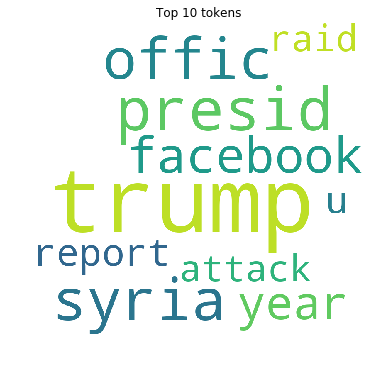

In [173]:
from collections import Counter
from wordcloud import WordCloud

data_visualization= data_processed.str.join(' ')  
cter=Counter(" ".join(data_visualization).split()).most_common(10)
#cterJoined=" ".join(cter)

dictCommon=dict(cter)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 1).generate_from_frequencies(dictCommon) 
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Top 10 tokens')

plt.show() 

### À cette étape on crée notre matrice TF-IDF avec la librairie scikit-learn. On utilise la fonction "dummy_fun" car on ne veut pas utiliser de tokenizer notre fonction de preprocessing se charge de créer les tokens suivant nos critères de sélection. Ainsi à l'attribut "preprocessor" du Vectorizer TF-IDF on assigne notre fonction qu'on a créé ci-dessus.On spécifie également l'attribut ngram_range à (1,2) qui signife qu'on va utiliser des bigrams et des mots uniques dans notre dictionnaire. On exécute suite à cela la fonction "fit" qui va créer notre matrice TF-IDF avec tout les mots de nos données.

In [267]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    ngram_range = (1,2),
    tokenizer=dummy_fun,
    preprocessor=preprocess,
    min_df=0.0001,
    token_pattern=None)

tfidf.fit(data['text']);

### On appele suite à cela "transform" qui va effectuer le calcul de la fréquence de chaque mot en utilisant la formule du TF-IDF puis on récupère ce résultat dans "tf_idf_matrix"

In [175]:
tf_idf_matrix = tfidf.transform(data['text'])

## DBSCAN

### Description( Résultats pas a jour)

In [176]:


dbscan = DBSCAN(eps=0.6, min_samples=5, metric='cosine', algorithm='brute')
labels = dbscan.fit_predict(tf_idf_matrix)

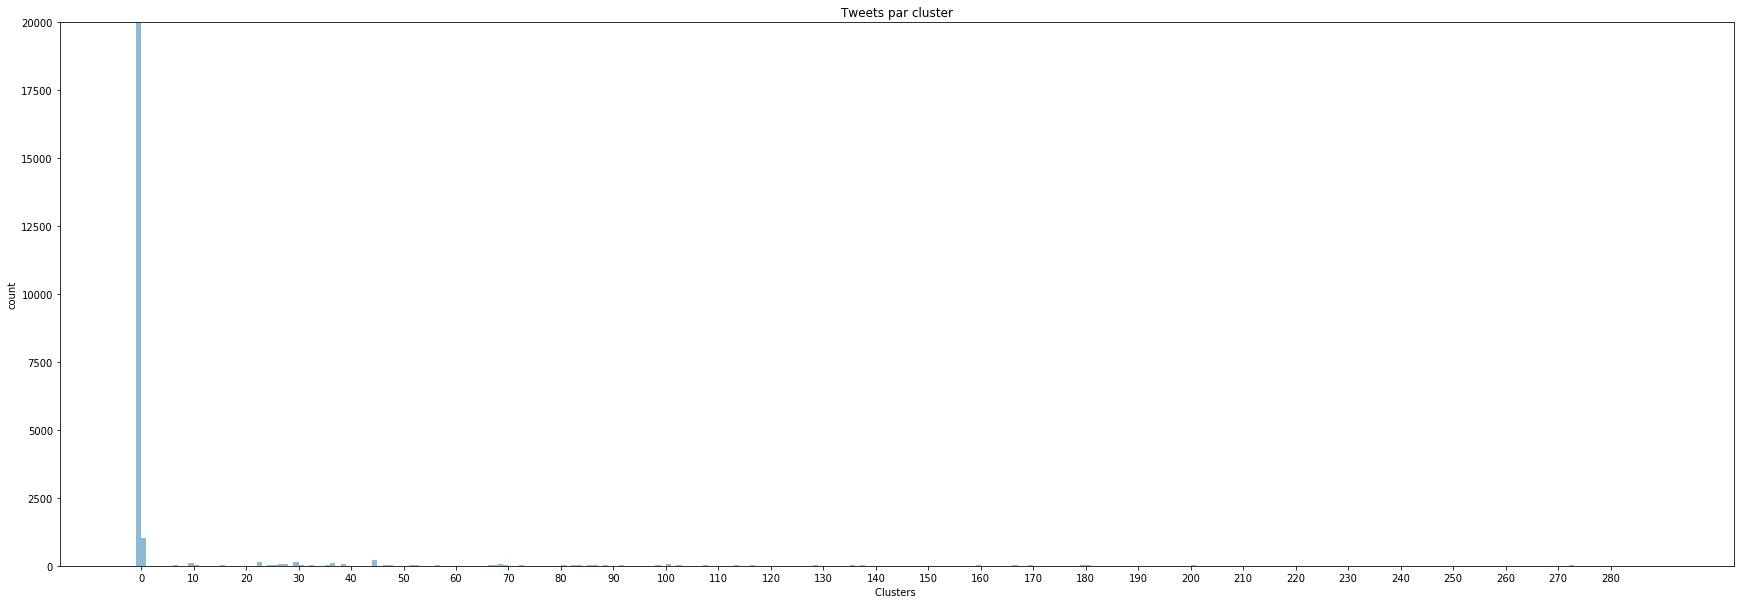

In [177]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

toShow=np.array(labels)   

bins = n_clusters # fixed bin size

# plt.xlim([min(toShow), max(toShow)])
plt.figure(figsize=(30,10))
plt.ylim(0,20000)

plt.xticks(np.arange(n_clusters, step=10))

plt.hist(toShow, bins=bins, alpha=0.5)
plt.title('Tweets par cluster')
plt.xlabel('Clusters ')
plt.ylabel('count')

plt.show()

In [178]:
from sklearn.metrics import calinski_harabasz_score

# print(calinski_harabasz_score(tf_idf_matrix.toarray(), labels))

ImportError: cannot import name 'calinski_harabasz_score' from 'sklearn.metrics' (C:\Users\Ghassen Cherni\Anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

## K-mean

### Description

In [188]:
from sklearn.cluster import MiniBatchKMeans
random_state = 0
n_clusters=16
cls = MiniBatchKMeans(n_clusters, init_size=1024, batch_size=2048, random_state=20)  #Essayer Kmean et hyperparameter tuning
cls.fit(tf_idf_matrix)

cls.predict(tf_idf_matrix)
lf=cls.labels_
f=lf.tolist()

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters


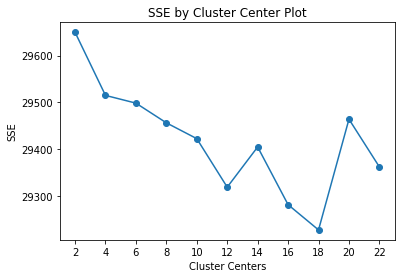

In [189]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(tf_idf_matrix, 22)

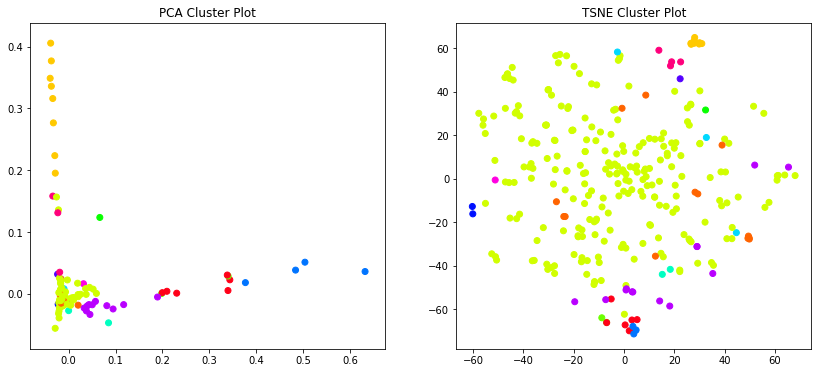

In [190]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

clusters = MiniBatchKMeans(n_clusters=16, init_size=1024, batch_size=2048, random_state=20).fit_predict(tf_idf_matrix)
plot_tsne_pca(tf_idf_matrix, clusters)
    

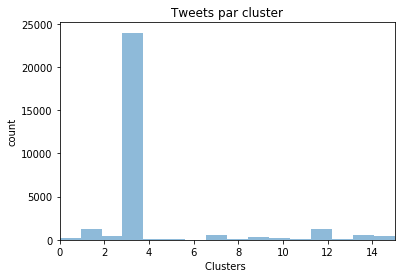

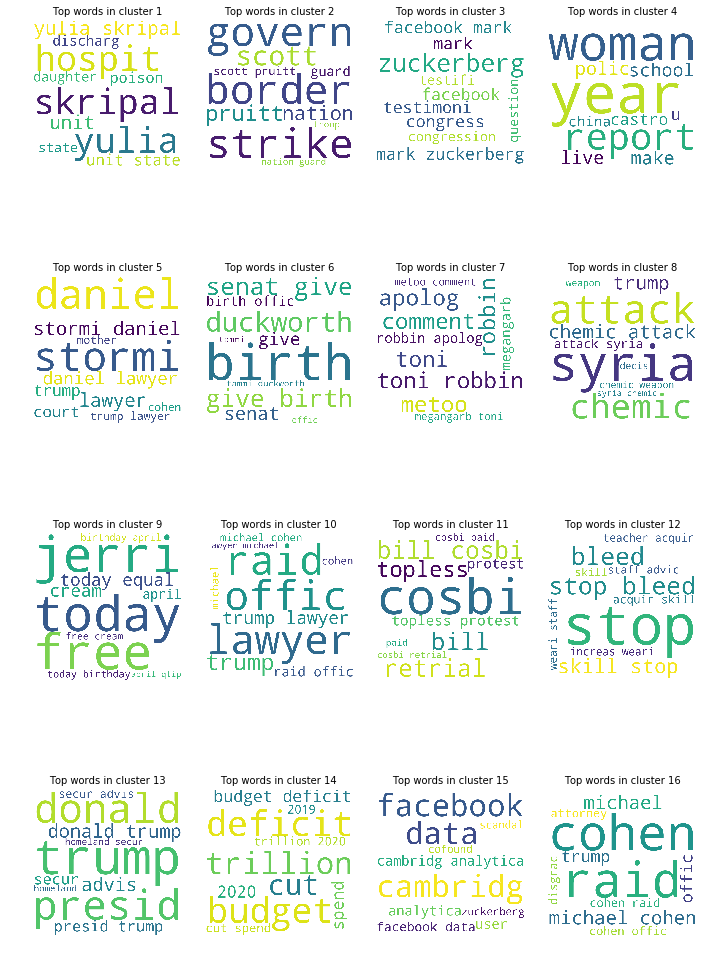

In [191]:
#print("Top terms per cluster:")
lf=cls.labels_
f=lf.tolist()
topWords = [ [ 0 for i in range(10) ] for j in range(16) ] 
order_centroids = cls.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(16):
    #print("Cluster %d:" % i, end='')
    j=0
    for ind in order_centroids[i, :10]:
       # print(' %s' % terms[ind], end='')
        topWords[i][j]=terms[ind]
       # print()
        j+=1

        
toShow=np.array(f)        
bins = 16 # fixed bin size

plt.xlim([min(toShow), max(toShow)])

plt.hist(toShow, bins=bins, alpha=0.5)
plt.title('Tweets par cluster')
plt.xlabel('Clusters ')
plt.ylabel('count')

plt.show()      

#convert it to dictionary with values and its occurences
from collections import Counter
fig, axes = plt.subplots(4,4 , figsize=(10,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    word_could_dict=Counter(topWords[i])
    wordcloud.generate_from_frequencies(word_could_dict, max_font_size=300)
    plt.gca().imshow(wordcloud)
    plt.gca().set_title('Top words in cluster ' + str(i+1), fontdict=dict(size=10))
    plt.gca().axis("off")
    #plt.gca().title('Top 10 tokens')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()





## Latent Dirichlet Allocation

### Description

In [261]:

processed_data=data_processed

## Cette partie permet de generer des trigrams d'une facon assez particuliere, en effet on ne genere pas les 
#  tout les trigrams possibles, on ne genere que les trigrams dont l'apparition dans les tweets depasse un certains
#  seuil, par exemple si le trigramm "Mr Donald Trump" apparait plus de 100 fois on generera le trigramm correspondant
bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=50)   
trigram = gensim.models.Phrases(bigram[processed_data], threshold=50)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
#bigrammed=bigram_mod[processed_data] #Demander si cette methode est effective
trigrammed=trigram_mod[bigram_mod[processed_data]]
####################################################################



dictionary = gensim.corpora.Dictionary(trigrammed) #ici on genere le dictionnaire

## On filtre les extremes dans les dictionnaires, ici on ne garde que les tokens qui apparaissent dans au moins 15 tweets
#  et on supprime ceux qui apparaissent dans plus de 50% des tweets, et finalement on ne garde que les 100 000 tokens 
#  les plus significatifs.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)


bow_corpus = [dictionary.doc2bow(doc) for doc in trigrammed] # on crée notre bag of words

## On crée notre modele tfidf et on l'applique sur le bag of words qu'on avait generé
tfidf = models.TfidfModel(bow_corpus) 
corpus_tfidf = tfidf[bow_corpus]

## On crée le modele LDA en se basant sur une de ses variantes, LDA multicore, qui permet d'utiliser l'ensemble des 
#  coeurs ("core") du processeur de l'ordinateur, permettant ainsi de gagner considerablement en temps d'entrainement
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=30, id2word=dictionary, passes=2, workers=2)

## Ici on affiche les mots de chaque topic/sujet 
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.032*"report" + 0.029*"rais" + 0.029*"offici" + 0.029*"2018" + 0.029*"year" + 0.022*"name" + 0.017*"fund" + 0.017*"hospit" + 0.014*"social_medium" + 0.014*"price"
Topic: 1 
Words: 0.034*"thing" + 0.030*"univers" + 0.027*"approv" + 0.022*"student" + 0.018*"reach" + 0.017*"cut" + 0.015*"make" + 0.014*"campus" + 0.012*"back" + 0.012*"kid"
Topic: 2 
Words: 0.029*"florida" + 0.020*"teen" + 0.020*"u" + 0.016*"report" + 0.014*"demand" + 0.014*"isra" + 0.013*"space" + 0.012*"charg" + 0.012*"pick" + 0.011*"rank"
Topic: 3 
Words: 0.029*"happen" + 0.026*"campaign" + 0.018*"judg" + 0.017*"countri" + 0.016*"tuesday" + 0.013*"provid" + 0.012*"opportun" + 0.011*"citi_council" + 0.010*"publish" + 0.010*"author"
Topic: 4 
Words: 0.028*"tweet" + 0.021*"market" + 0.019*"hope" + 0.018*"power" + 0.018*"show" + 0.018*"class" + 0.018*"analysi" + 0.018*"presid" + 0.017*"trump" + 0.017*"honor"
Topic: 5 
Words: 0.029*"star" + 0.025*"find" + 0.017*"restaur" + 0.016*"schedul" + 0.015*"street" + 

In [213]:
# # Evaluation du modele
#  Afin d'evaluer notre modele, nous allons utiliser 2 types d'evaluations:
#  -Evaluation à l'oeil nue: Quels sujets sont assignés à chaque document (on examinera un echantillon), 
#  et quels sont les mots assignés à chaque sujet
#  -Evaluation intrinseque: Interpretabilité de chaque sujet, et analyse de la semantique du modele.
#  Pour ce type d'evaluation on a choisi 2 mesures, la perplexité et la coherence. 
#  La perplexité etant une mesure indiquant la capacité de notre modele à predire un texte qu'on lui donne en input
#  et par predire on veut dire l'assignation de probabilité. Plus la perplexité est basse, plus le modele est 
#  capable d'assigner ces probabilités. Cependant on ne peut utiliser cette mesure seule, car recemment des etudes 
#  on montré qu'il n'y a pas necessairement une correlation entre la perplexité et l'interpratibilité d'un texte par un
#  etre humain
#  Quant à la coherence, elle permet d'evaluer, pour chaque sujet, le degré de similatrité entre les mots le composant
#  On a choisi ces deux methodes de mesures à cause de leur preponderence en tant que methodes d'evaluations dans la 
#  plupart de nos references.



# Perplexity:
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Coherence Score: 
coherence_model_lda = CoherenceModel(model=lda_model, texts=trigrammed, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -8.362527814873562

Coherence Score:  0.49131978329433956


In [8]:
## On evalue la perplexité et la coherence dans les cas ou on utilise les unigrams, bigrams et trigrams, 
#  on remarque que l'utilisation des trigrams permet d'avoir des meilleurs résultats pour les metriques choisies

display_Evaluation=pd.DataFrame({
    "Evaluation Metric":["Perplexity","Coherence"],
    "Unigrams":[-8.0124869679534,0.4746898688912405],
    "Bigrams":[-8.165684388747467,0.4887599985701607],
    "Trigrams":[-8.226355592341983,0.5086177373007298]
})
from IPython.display import display, HTML
display(HTML(display_Evaluation.to_html(index=False)))

Evaluation Metric,Unigrams,Bigrams,Trigrams
Perplexity,-8.012487,-8.165684,-8.226356
Coherence,0.474690,0.488760,0.508618


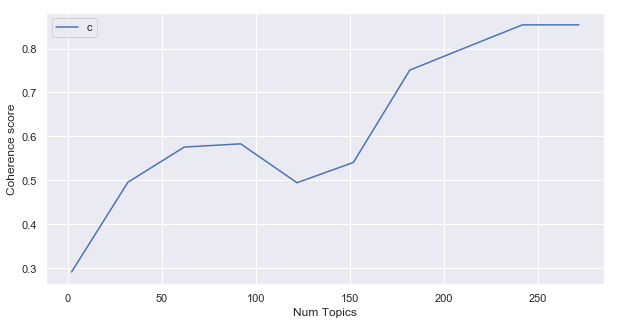

In [247]:
## Model hyperparameter tuning
#  Afin de choisir le nombre optimal de sujet/topics on effectue un "hyperparameter tuning", l'on a choisi la 
#  coherence comme mesure à optimiser pour choisir le nombre de sujets.


from tqdm.autonotebook import tqdm
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplexity_value=[]
    model_list = []
    pbar = tqdm(total=10)

    i=0
    for num_topics in range(start, limit, step):
        i+=1
        lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=2)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        #perplexity_values.append(lda_model.log_perplexity(bow_corpus))
        pbar.update(1)

    return model_list, coherence_values,#perplexity_values



# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=trigrammed, start=2, limit=300, step=30)

limit=300; start=2; step=30;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [265]:
# Visualize the topics
## Cette methode de visualisatione st specifique à gensim, elle permet de visualiser pour chaque cluster (topic) 
#  les mots les plus présents et le pourcentage du mot present dans le cluster par rapport à tout les clusters
#  On peut aussi voir...
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

C:\Users\Ghassen Cherni\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22     0.255498  0.120307       1        1  4.170712
7     -0.124122  0.058666       2        1  4.027239
9      0.133144 -0.157904       3        1  3.867758
27     0.042063  0.080919       4        1  3.848979
16     0.224849 -0.020330       5        1  3.845121
8      0.016371  0.079451       6        1  3.598864
26    -0.095765  0.113102       7        1  3.500546
5     -0.117271 -0.051854       8        1  3.471331
15    -0.103697  0.000478       9        1  3.470149
12    -0.011926 -0.174107      10        1  3.453600
20    -0.077822 -0.043098      11        1  3.432814
28    -0.070116  0.073275      12        1  3.358860
25    -0.094392 -0.051416      13        1  3.342682
0     -0.049132 -0.011806      14        1  3.334477
19    -0.054736 -0.102612      15        1  3.312547
13     0.097523 -0.179184      16        1  3.257681
24     0.104516  0.072106      17        1  3.244440
17    -0.009771 -0.049846      18        1  3.187899
18    -0.011497 -0.002487      19        1  3.175195
4      0.035312  0.074980      20        1  3.168357
1     -0.050547  0.048624      21        1  3.142938
21    -0.031183 -0.053401      22        1  3.091046
11    -0.057098  0.083266      23        1  3.009587
3     -0.053574  0.026141      24        1  3.002157
6      0.090413  0.069111      25        1  2.998768
2     -0.005519 -0.095021      26        1  2.974597
23    -0.083782  0.039140      27        1  2.965633
14    -0.029504 -0.049596      28        1  2.942005
29    -0.070077  0.077788      29        1  2.937930
10     0.201842  0.025307      30        1  2.866098, topic_info=     Category         Freq                Term        Total  loglift  logprob
42    Default  2651.000000               trump  2651.000000  30.0000  30.0000
287   Default   840.000000               offic   840.000000  29.0000  29.0000
942   Default   614.000000                raid   614.000000  28.0000  28.0000
151   Default   910.000000               syria   910.000000  27.0000  27.0000
158   Default   537.000000               break   537.000000  26.0000  26.0000
494   Default   367.000000              lawyer   367.000000  25.0000  25.0000
23    Default   760.000000              presid   760.000000  24.0000  24.0000
365   Default   548.000000             student   548.000000  23.0000  23.0000
322   Default   677.000000                   u   677.000000  22.0000  22.0000
1714  Default   300.000000              counti   300.000000  21.0000  21.0000
622   Default   705.000000            facebook   705.000000  20.0000  20.0000
168   Default   424.000000                call   424.000000  19.0000  19.0000
555   Default   270.000000                game   270.000000  18.0000  18.0000
326   Default   444.000000                read   444.000000  17.0000  17.0000
689   Default   406.000000               video   406.000000  16.0000  16.0000
624   Default   228.000000                good   228.000000  15.0000  15.0000
1185  Default   344.000000               senat   344.000000  14.0000  14.0000
782   Default   305.000000               stori   305.000000  13.0000  13.0000
1397  Default   295.000000             respons   295.000000  12.0000  12.0000
497   Default   244.000000              strike   244.000000  11.0000  11.0000
819   Default   198.000000                love   198.000000  10.0000  10.0000
878   Default   257.000000              latest   257.000000   9.0000   9.0000
1638  Default   246.000000     mark_zuckerberg   246.000000   8.0000   8.0000
424   Default   220.000000               thing   220.000000   7.0000   7.0000
1288  Default   206.000000              spring   206.000000   6.0000   6.0000
1842  Default   199.000000       michael_cohen   199.000000   5.0000   5.0000
1079  Default   182.000000               build   182.000000   4.0000   4.0000
149   Default   861.000000              report   861.000000   3.0000   3.0000

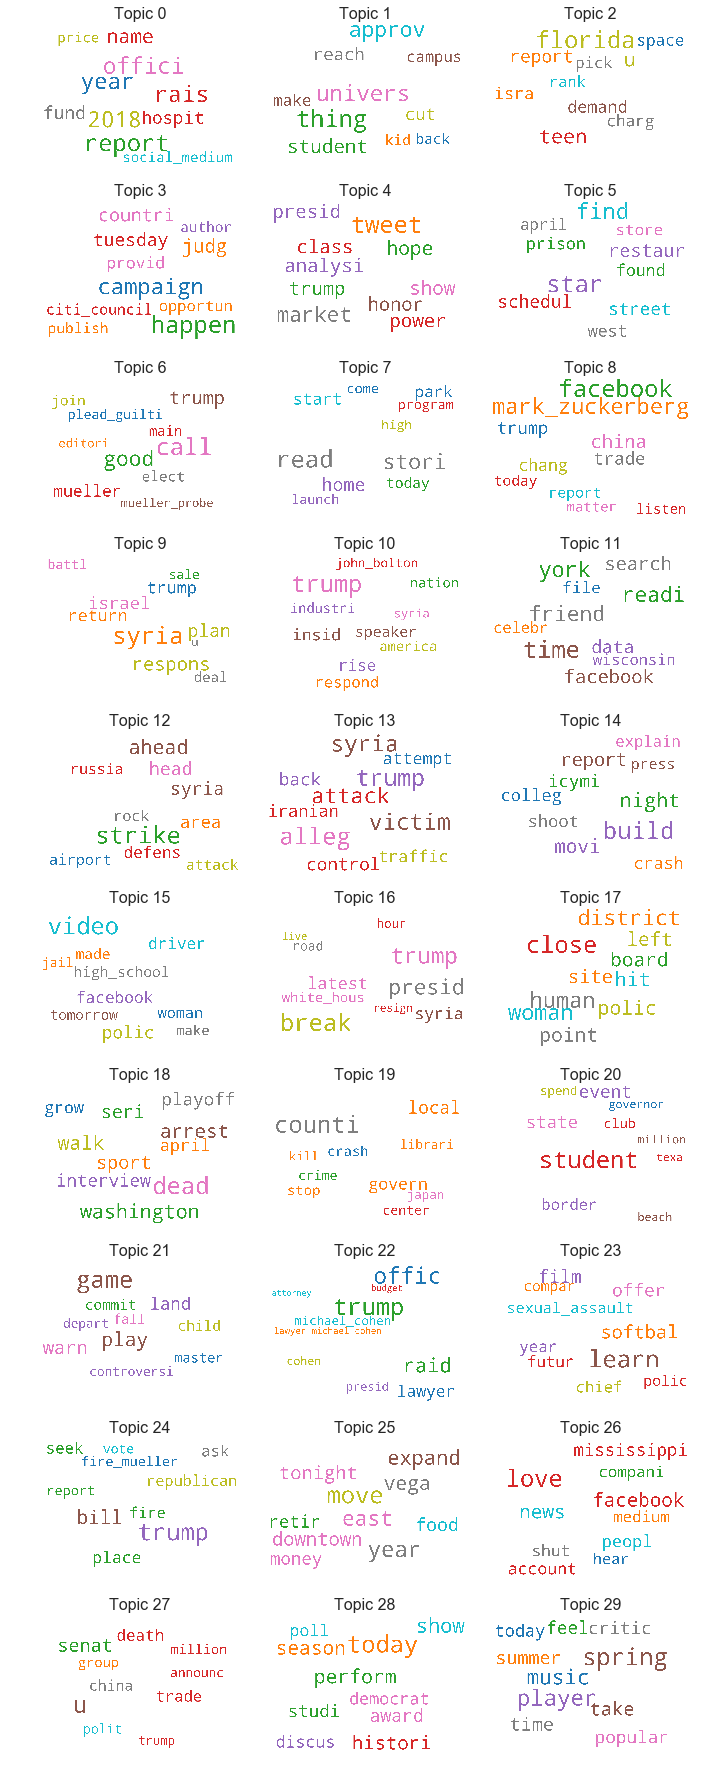

In [262]:
import matplotlib.colors as mcolors

## On genere ici les wordclouds affichant les 10 mots les plus important pour chaque cluster




cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=30,formatted=False)

fig, axes = plt.subplots(10,3 , figsize=(10,25), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

[(2, 0.41077524), (13, 0.15183538), (16, 0.15860286), (24, 0.13431804)]
Tweets par cluster


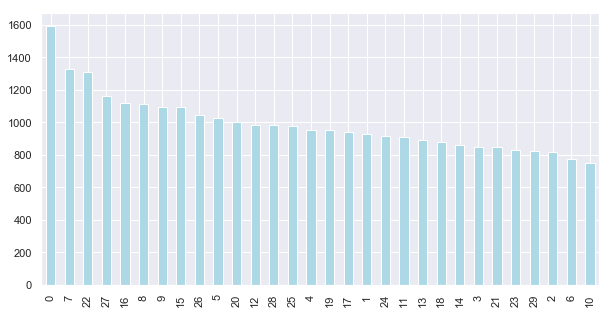

In [264]:
## On affiche ici le nombre de tweets dans chaque cluster, un tweet ayant le sujet 1 comme sujet le plus 
#  important sera classé dans le cluster relatif au sujet 1.

print(lda_model[bow_corpus[8]])
import seaborn as sns;
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics = [lda_model[bow_corpus[i]] for i in range(len(trigrammed))]

document_topic = pd.concat([topics_document_to_dataframe(topics_document, num_topics=30) for topics_document in topics]) .reset_index(drop=True).fillna(0)

print("Tweets par cluster")
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')



In [266]:
##  Ici on affiche pour un echantillon de tweets le sujet le plus important.

def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=trigrammed)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.6778,"call, good, trump, mueller, elect, join, main,...","[timelin, fidel_castro, life]"
1,1,21.0,0.3410,"game, play, warn, land, child, commit, master,...","[poll, open, kuwait, opposit, return]"
2,2,14.0,0.4655,"build, night, movi, report, icymi, shoot, coll...","[havana, music, stop, cuban, mourn, father, ca..."
3,3,7.0,0.4915,"read, stori, home, start, park, today, come, l...","[foldabl, cardboard, tube, bring, easi, test, ..."
4,4,13.0,0.7583,"alleg, trump, syria, victim, attack, control, ...","[mariann, faithful, pay, homag, pari, victim, ..."
5,5,13.0,0.3398,"alleg, trump, syria, victim, attack, control, ...","[pope, everyman, reaction, death, cuban, presi..."
6,6,18.0,0.6570,"dead, washington, walk, arrest, sport, seri, p...","[iran, arrest, dead, train, crash]"
7,7,18.0,0.4048,"dead, washington, walk, arrest, sport, seri, p...","[fidelcastro, brutal_dictat, legaci, oppress, ..."
8,8,2.0,0.4104,"florida, teen, u, report, demand, isra, space,...","[thousand, ralli, demand, korea, presid, ouster]"
9,9,10.0,0.6777,"trump, insid, rise, respond, speaker, america,...","[remind, barack_obama, month]"
